# Phase 3 (v2) — Solvers & Benchmarks with **QPU + Hybrid** (Robust)

This is an updated Phase 3 notebook that:
- keeps the robust **Exact / SA / Tabu** baselines,
- **adds real quantum annealing runs**:
  - **QPU** (hardware) via `DWaveSampler` + (cached) `minorminer` embedding
  - **Hybrid** via `LeapHybridSampler`
- makes method-specific size limits so you can push to **non-toy** sizes safely.

## Important note about “increasing n”
Phase 3 can only solve the instances produced by Phase 2 (`phase2_qubo_artifacts.json`).
To increase `n`, you must:
1) update `CONFIG["n_list"]` in **Phase 1**,
2) rerun **Phase 1 → Phase 2** to regenerate `phase2_qubo_artifacts.json`,
3) then rerun this notebook.

This notebook will **detect** the max n present and warn if it's smaller than your target.


## 0) Imports + dependency checks

In [11]:
import os, json, ast, time, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Any

def try_import(name: str):
    try:
        mod = __import__(name)
        return mod, None
    except Exception as e:
        return None, e

dimod, dimod_err = try_import("dimod")
neal, neal_err = try_import("neal")  # package is dwave-neal, import name is neal
tabu_mod, tabu_err = try_import("tabu")  # dwave-tabu

dwave_system, dwave_system_err = try_import("dwave.system")
dwave_cloud, dwave_cloud_err = try_import("dwave.cloud")
minorminer, minorminer_err = try_import("minorminer")

print("dimod:", "OK" if dimod else f"missing ({dimod_err})")
print("neal :", "OK" if neal else f"missing ({neal_err})  -> pip install dwave-neal")
print("tabu :", "OK" if tabu_mod else f"missing ({tabu_err}) -> pip install dwave-tabu")
print("dwave.system:", "OK" if dwave_system else f"missing ({dwave_system_err}) -> pip install dwave-system")
print("dwave.cloud :", "OK" if dwave_cloud else f"missing ({dwave_cloud_err}) -> pip install dwave-cloud-client")
print("minorminer  :", "OK" if minorminer else f"missing ({minorminer_err}) -> pip install minorminer")


dimod: OK
neal : OK
tabu : OK
dwave.system: OK
dwave.cloud : OK
minorminer  : OK


## 1) Load Phase 2 artifacts (QUBOs)

In [12]:
PHASE2_JSON = "phase2_qubo_artifacts.json"  # change if needed

if not os.path.exists(PHASE2_JSON):
    raise FileNotFoundError(
        f"Could not find {PHASE2_JSON}. Put this notebook in the same folder as Phase 2 output, "
        "or update PHASE2_JSON."
    )

with open(PHASE2_JSON, "r") as f:
    artifact = json.load(f)

CONFIG = artifact.get("CONFIG", {})
INSTANCE_KEYS = artifact["INSTANCE_KEYS"]
INSTANCES = artifact["INSTANCES"]

# quick overview
ns = sorted({int(INSTANCES[k]["n"]) for k in INSTANCE_KEYS})
print("Loaded instances:", len(INSTANCE_KEYS))
print("n values present:", ns, "max n =", max(ns))

# If you WANT bigger n, you must regenerate Phase1/Phase2 with bigger CONFIG["n_list"].
TARGET_MAX_N = 80  # you can change
if max(ns) < TARGET_MAX_N:
    print(f"⚠️ Your artifacts only go up to n={max(ns)}. To reach n~{TARGET_MAX_N}, rerun Phase 1+2 with a larger n_list.")


Loaded instances: 12
n values present: [8, 12, 16, 20] max n = 20
⚠️ Your artifacts only go up to n=20. To reach n~80, rerun Phase 1+2 with a larger n_list.


## 2) Utilities: parse keys, reconstruct Q, energies

In [13]:
def parse_key(key_str: str):
    import ast as _ast
    return _ast.literal_eval(key_str)

def triplets_to_qubo(trips):
    return {(int(i), int(j)): float(v) for (i, j, v) in trips}

def qubo_energy(z: np.ndarray, Q: Dict[Tuple[int, int], float]) -> float:
    z = np.asarray(z, dtype=int)
    E = 0.0
    for (i, j), v in Q.items():
        E += v * z[i] * z[j]
    return float(E)

def markowitz_cost(z: np.ndarray, mu: np.ndarray, Sigma: np.ndarray, q: float) -> float:
    z = np.asarray(z, dtype=int)
    return float(q * (z @ Sigma @ z) - (1.0 - q) * (mu @ z))

def penalty_cost(z: np.ndarray, B: int, A: float) -> float:
    s = int(np.sum(z))
    return float(A * (s - B) ** 2)

def feasible(z: np.ndarray, B: int) -> bool:
    return int(np.sum(z)) == int(B)

def to_bitarray(sample: Dict[int, int], n: int) -> np.ndarray:
    z = np.zeros(n, dtype=int)
    for i in range(n):
        z[i] = int(sample.get(i, 0))
    return z

def qubo_to_bqm(Q: Dict[Tuple[int, int], float]):
    if not dimod:
        return None
    return dimod.BinaryQuadraticModel.from_qubo(Q)

def sampleset_to_best_z(sampleset, n: int) -> np.ndarray:
    best_idx = int(np.argmin(sampleset.record.energy))
    sample_row = sampleset.record.sample[best_idx]
    sdict = dict(zip(sampleset.variables, sample_row))
    return to_bitarray(sdict, n)


## 3) Build instance objects

In [14]:
def build_instance_objects(artifact_instances: Dict[str, Any]) -> Dict[str, Any]:
    inst_objs = {}
    for key_str, blob in artifact_instances.items():
        Q = triplets_to_qubo(blob["Q_triplets"])
        inst_objs[key_str] = {
            "key_str": key_str,
            "key": parse_key(key_str),
            "n": int(blob["n"]),
            "B": int(blob["B"]),
            "q": float(blob["q"]),
            "A": float(blob["A"]),
            "seed": int(blob.get("seed", 0)),
            "mu": np.array(blob["mu"], dtype=float),
            "Sigma": np.array(blob["Sigma"], dtype=float),
            "Q": Q,
            "meta": blob.get("meta", {}),
        }
    return inst_objs

INSTANCE_OBJECTS = build_instance_objects(INSTANCES)
print("Built instance objects:", len(INSTANCE_OBJECTS))


Built instance objects: 12


## 4) Classical solvers (Exact, SA, Tabu) + local improvement

In [15]:
def brute_force_best(n: int, energy_fn):
    best_E = float("inf")
    best_z = None
    for bits in itertools.product([0, 1], repeat=n):
        z = np.fromiter(bits, dtype=int, count=n)
        E = energy_fn(z)
        if E < best_E:
            best_E = E
            best_z = z.copy()
    return best_z, float(best_E)

def solve_exact(qubo: Dict[Tuple[int,int], float], n: int):
    t0 = time.time()
    if dimod:
        bqm = qubo_to_bqm(qubo)
        sampler = dimod.ExactSolver()
        ss = sampler.sample(bqm)
        z = sampleset_to_best_z(ss, n)
        E = float(ss.first.energy)
        return {"z_best": z, "E_best": E, "runtime_s": time.time() - t0, "engine": "dimod.ExactSolver"}
    else:
        z, E = brute_force_best(n, lambda z_: qubo_energy(z_, qubo))
        return {"z_best": z, "E_best": E, "runtime_s": time.time() - t0, "engine": "bruteforce"}

def delta_energy_flip(z: np.ndarray, k: int, Q: Dict[Tuple[int,int], float]) -> float:
    zk = int(z[k])
    zkp = 1 - zk
    dE = 0.0
    dE += Q.get((k, k), 0.0) * (zkp - zk)
    for i in range(0, k):
        qik = Q.get((i, k), 0.0)
        if qik != 0.0:
            dE += qik * int(z[i]) * (zkp - zk)
    n = len(z)
    for j in range(k + 1, n):
        qkj = Q.get((k, j), 0.0)
        if qkj != 0.0:
            dE += qkj * int(z[j]) * (zkp - zk)
    return float(dE)

def solve_sa_python(
    Q: Dict[Tuple[int,int], float],
    n: int,
    num_reads: int = 400,
    sweeps: int = 4000,
    T_start: float = 5.0,
    T_end: float = 0.01,
    seed: int = 0,
):
    rng = np.random.default_rng(seed)
    t0 = time.time()
    best_E = float("inf")
    best_z = None
    temps = np.exp(np.linspace(np.log(T_start), np.log(T_end), max(2, sweeps)))
    for _ in range(num_reads):
        z = rng.integers(0, 2, size=n, dtype=int)
        E = qubo_energy(z, Q)
        for T in temps:
            k = int(rng.integers(0, n))
            dE = delta_energy_flip(z, k, Q)
            if dE <= 0 or rng.random() < math.exp(-dE / max(T, 1e-12)):
                z[k] = 1 - z[k]
                E += dE
        if E < best_E:
            best_E = float(E)
            best_z = z.copy()
    return {"z_best": best_z, "E_best": float(best_E), "runtime_s": time.time() - t0, "engine": "python.SA"}

def solve_sa(Q: Dict[Tuple[int,int], float], n: int, num_reads: int = 1000, sweeps: int = 8000, seed: int = 0):
    t0 = time.time()
    if neal and dimod:
        bqm = qubo_to_bqm(Q)
        sampler = neal.SimulatedAnnealingSampler()
        ss = sampler.sample(bqm, num_reads=num_reads, num_sweeps=sweeps, seed=seed)
        z = sampleset_to_best_z(ss, n)
        E = float(ss.first.energy)
        return {"z_best": z, "E_best": E, "runtime_s": time.time() - t0, "engine": "neal.SA", "sampleset": ss}
    return solve_sa_python(Q, n, num_reads=num_reads, sweeps=sweeps, seed=seed)

def solve_tabu(Q: Dict[Tuple[int,int], float], n: int, timeout: int = 5000, seed: int = 0):
    if not (tabu_mod and dimod):
        return None
    t0 = time.time()
    bqm = qubo_to_bqm(Q)
    sampler = tabu_mod.TabuSampler()
    try:
        ss = sampler.sample(bqm, timeout=timeout, seed=seed)
    except TypeError:
        ss = sampler.sample(bqm, timeout=timeout)
    z = sampleset_to_best_z(ss, n)
    E = float(ss.first.energy)
    return {"z_best": z, "E_best": E, "runtime_s": time.time() - t0, "engine": "tabu", "sampleset": ss}

def local_improve_python(z0: np.ndarray, Q: Dict[Tuple[int,int], float], max_passes: int = 10):
    z = np.asarray(z0, dtype=int).copy()
    E = qubo_energy(z, Q)
    n = len(z)
    for _ in range(max_passes):
        best_dE = 0.0
        best_k = None
        for k in range(n):
            dE = delta_energy_flip(z, k, Q)
            if dE < best_dE:
                best_dE = dE
                best_k = k
        if best_k is None:
            break
        z[best_k] = 1 - z[best_k]
        E += best_dE
    return z, float(E)

def local_improve(z0: np.ndarray, Q: Dict[Tuple[int,int], float]):
    if dimod:
        try:
            bqm = qubo_to_bqm(Q)
            solver = dimod.SteepestDescentSolver()
            init = [{i: int(z0[i]) for i in range(len(z0))}]
            ss = solver.sample(bqm, initial_states=init, num_reads=1)
            z = sampleset_to_best_z(ss, len(z0))
            return z, float(ss.first.energy), "dimod.SteepestDescent"
        except Exception:
            pass
    z, E = local_improve_python(z0, Q)
    return z, E, "python.local_descent"


## 5) QPU/HW helpers: choose solver, build hardware graph, cache embeddings

In [16]:
# ---- QPU discovery ----
def get_qpu_solvers():
    if not dwave_cloud:
        return []
    from dwave.cloud import Client
    with Client.from_config() as client:
        solvers = client.get_solvers()
        if isinstance(solvers, dict):
            solvers = list(solvers.values())
        else:
            solvers = list(solvers)
    return [s for s in solvers if getattr(s, "qpu", False)]

QPU_SOLVERS = get_qpu_solvers()
if len(QPU_SOLVERS) > 0:
    print("Found QPU solvers:", [s.name for s in QPU_SOLVERS][:10])
    DEFAULT_QPU_SOLVER = QPU_SOLVERS[0].name
    print("Default QPU solver:", DEFAULT_QPU_SOLVER)
else:
    DEFAULT_QPU_SOLVER = None
    print("No QPU solvers found via dwave-cloud. If you expected one, run: dwave config create")

# ---- Hardware graph edges ----
_HW_CACHE = {}

def get_working_hw_edges(solver_name: str):
    if solver_name in _HW_CACHE:
        return _HW_CACHE[solver_name]
    if not dwave_system:
        raise RuntimeError("dwave-system not available")
    from dwave.system import DWaveSampler
    sampler = DWaveSampler(solver=solver_name)
    hw_graph = sampler.to_networkx_graph()
    # Optionally restrict to working qubits if provided by solver props:
    try:
        working_qubits = sampler.properties.get("working_qubits", None)
        if working_qubits is not None:
            hw_graph = hw_graph.subgraph(working_qubits).copy()
    except Exception:
        pass
    hw_edges = list(hw_graph.edges())
    _HW_CACHE[solver_name] = (hw_edges, hw_graph.number_of_nodes())
    return _HW_CACHE[solver_name]

# ---- Build logical graph from BQM / QUBO ----
def logical_edges_from_qubo(Q: Dict[Tuple[int,int], float]):
    # include only quadratic couplers i<j with nonzero weight
    return [(i, j) for (i, j), v in Q.items() if i != j and abs(v) > 0]

def embedding_stats(embedding: Dict[int, list]):
    # embedding: logical var -> list of physical qubits
    chain_lengths = [len(v) for v in embedding.values()]
    if len(chain_lengths) == 0:
        return {"mean_chain": np.nan, "max_chain": np.nan, "n_logical": 0}
    return {"mean_chain": float(np.mean(chain_lengths)), "max_chain": int(np.max(chain_lengths)), "n_logical": int(len(chain_lengths))}

# ---- Embedding cache keyed by (solver_name, instance_key) ----
_EMB_CACHE = {}

def find_embedding_for_instance(instance_key: str, Q: Dict[Tuple[int,int], float], solver_name: str, timeout: int = 10, seed: int = 0):
    """
    Returns embedding dict {logical_var: [physical_qubits]} or None.
    """
    cache_key = (solver_name, instance_key)
    if cache_key in _EMB_CACHE:
        return _EMB_CACHE[cache_key]

    if minorminer is None:
        return None
    hw_edges, _ = get_working_hw_edges(solver_name)
    logical_edges = logical_edges_from_qubo(Q)

    # For dense QUBOs, embedding may be hard; timeout must be reasonable
    emb = minorminer.find_embedding(logical_edges, hw_edges, timeout=timeout, random_seed=seed)
    if not emb or len(emb) == 0:
        _EMB_CACHE[cache_key] = None
        return None
    _EMB_CACHE[cache_key] = emb
    return emb


Found QPU solvers: ['Advantage_system4.1', 'Advantage_system6.4', 'Advantage2_system1.8']
Default QPU solver: Advantage_system4.1


## 6) QPU + Hybrid solvers (real QA)

In [17]:
def choose_chain_strength_heuristic(Q: Dict[Tuple[int,int], float], multiplier: float = 1.5) -> float:
    # Simple scale heuristic: based on max absolute quadratic weight
    quads = [abs(v) for (i,j), v in Q.items() if i != j]
    if len(quads) == 0:
        return 1.0
    return float(multiplier * max(quads))

def solve_dwave_qpu_cached_embedding(
    Q: Dict[Tuple[int,int], float],
    n: int,
    instance_key: str,
    solver_name: Optional[str] = None,
    num_reads: int = 3000,
    chain_strength: Optional[float] = None,
    emb_timeout: int = 10,
    emb_seed: int = 0,
    annealing_time: Optional[int] = None,
):
    if not (dwave_system and dimod and minorminer and solver_name):
        return None

    from dwave.system import DWaveSampler, FixedEmbeddingComposite, EmbeddingComposite

    t0 = time.time()
    bqm = qubo_to_bqm(Q)

    if chain_strength is None:
        chain_strength = choose_chain_strength_heuristic(Q)

    sampler = DWaveSampler(solver=solver_name)

    # Try cached FixedEmbeddingComposite first for reproducibility + speed
    emb = find_embedding_for_instance(instance_key, Q, solver_name=solver_name, timeout=emb_timeout, seed=emb_seed)

    sampleset = None
    info = {}
    used = None

    kwargs = {"num_reads": num_reads, "chain_strength": chain_strength}
    if annealing_time is not None:
        kwargs["annealing_time"] = annealing_time

    if emb is not None:
        try:
            comp = FixedEmbeddingComposite(sampler, emb)
            sampleset = comp.sample(bqm, **kwargs)
            used = "FixedEmbeddingComposite(minorminer cached)"
            info["embedding_stats"] = embedding_stats(emb)
        except Exception as e:
            info["fixed_embedding_error"] = str(e)
            sampleset = None

    # Fall back to EmbeddingComposite if fixed embedding failed or not found
    if sampleset is None:
        comp = EmbeddingComposite(sampler)
        sampleset = comp.sample(bqm, **kwargs)
        used = "EmbeddingComposite(auto)"

    z = sampleset_to_best_z(sampleset, n)
    E = float(sampleset.first.energy)

    # Capture timing and chain breaks if present
    try:
        timing = sampleset.info.get("timing", {})
        info["timing"] = timing
    except Exception:
        pass

    try:
        if "chain_break_fraction" in sampleset.record.dtype.names:
            info["chain_break_fraction"] = float(sampleset.record.chain_break_fraction[int(np.argmin(sampleset.record.energy))])
    except Exception:
        pass

    return {
        "z_best": z,
        "E_best": E,
        "runtime_s": time.time() - t0,
        "engine": "dwave.QPU",
        "info": info,
        "qpu_solver": solver_name,
        "used_embedding": used,
        "chain_strength": float(chain_strength),
        "num_reads": int(num_reads),
    }

def solve_dwave_hybrid(Q: Dict[Tuple[int,int], float], n: int, time_limit: int = 10):
    if not (dwave_system and dimod):
        return None
    from dwave.system import LeapHybridSampler
    t0 = time.time()
    bqm = qubo_to_bqm(Q)
    sampler = LeapHybridSampler()
    sampleset = sampler.sample(bqm, time_limit=time_limit)
    z = sampleset_to_best_z(sampleset, n)
    E = float(sampleset.first.energy)
    return {
        "z_best": z,
        "E_best": E,
        "runtime_s": time.time() - t0,
        "engine": "dwave.Hybrid",
        "info": sampleset.info,
        "time_limit": int(time_limit),
    }


## 7) Runner: evaluate solutions and run each method with size guards

In [18]:
def evaluate_solution(z: np.ndarray, inst: Dict[str, Any]) -> Dict[str, Any]:
    mu = inst["mu"]
    Sigma = inst["Sigma"]
    q = float(inst["q"])
    B = int(inst["B"])
    A = float(inst["A"])
    Q = inst["Q"]
    return {
        "sum_z": int(np.sum(z)),
        "feasible": bool(feasible(z, B)),
        "F_markowitz": float(markowitz_cost(z, mu, Sigma, q)),
        "penalty": float(penalty_cost(z, B, A)),
        "E_qubo": float(qubo_energy(z, Q)),
    }

def run_one_method(inst: Dict[str, Any], method: str, params: Dict[str, Any]) -> Dict[str, Any]:
    n = int(inst["n"])
    Q = inst["Q"]
    key_str = inst["key_str"]

    # method-specific size guard
    max_n = params.get("max_n", 10**9)
    if n > max_n:
        return {"status": "skipped", "reason": f"n={n} > max_n={max_n}"}

    if method == "exact":
        sol = solve_exact(Q, n)

    elif method == "sa":
        sol = solve_sa(Q, n,
                       num_reads=params.get("num_reads", 1000),
                       sweeps=params.get("sweeps", 8000),
                       seed=params.get("seed", 0))

    elif method == "tabu":
        sol = solve_tabu(Q, n,
                         timeout=params.get("timeout", 5000),
                         seed=params.get("seed", 0))
        if sol is None:
            return {"status": "skipped", "reason": "tabu/dimod not available"}

    elif method == "dwave_hybrid":
        sol = solve_dwave_hybrid(Q, n, time_limit=params.get("time_limit", 10))
        if sol is None:
            return {"status": "skipped", "reason": "dwave-system/dimod not available or credentials missing"}

    elif method == "dwave_qpu":
        solver_name = params.get("solver_name", DEFAULT_QPU_SOLVER)
        if solver_name is None:
            return {"status": "skipped", "reason": "no QPU solver detected"}
        sol = solve_dwave_qpu_cached_embedding(
            Q, n, instance_key=key_str,
            solver_name=solver_name,
            num_reads=params.get("num_reads", 3000),
            chain_strength=params.get("chain_strength", None),
            emb_timeout=params.get("emb_timeout", 10),
            emb_seed=params.get("emb_seed", 0),
            annealing_time=params.get("annealing_time", None),
        )
        if sol is None:
            return {"status": "skipped", "reason": "QPU not available (libs or credentials)"}

    else:
        return {"status": "skipped", "reason": f"unknown method {method}"}

    z = sol["z_best"]
    E = sol["E_best"]
    runtime = float(sol.get("runtime_s", np.nan))

    # local improvement
    z_imp, E_imp, imp_engine = local_improve(z, Q)
    met = evaluate_solution(z, inst)
    met_imp = evaluate_solution(z_imp, inst)

    out = {
        "status": "ok",
        "engine": sol.get("engine", method),
        "runtime_s": runtime,
        "E_best": float(E),
        "E_best_improved": float(E_imp),
        "improve_engine": imp_engine,
        **{f"raw_{k}": v for k, v in met.items()},
        **{f"imp_{k}": v for k, v in met_imp.items()},
        "z_best": z.astype(int).tolist(),
        "z_best_improved": z_imp.astype(int).tolist(),
    }

    if "info" in sol and isinstance(sol["info"], dict):
        out["solver_info"] = sol["info"]

    # keep a few qpu knobs for reproducibility
    for k in ["qpu_solver", "used_embedding", "chain_strength", "num_reads", "time_limit"]:
        if k in sol:
            out[k] = sol[k]

    return out


## 8) Configure experiment: methods + size policy (non-toy)

Guidance:
- **Exact**: only for small n (e.g. ≤ 20)
- **SA/Tabu**: can run bigger n locally (e.g. up to 200)
- **Hybrid**: great for dense problems up to hundreds+
- **QPU**: for dense Markowitz QUBOs, keep small (e.g. ≤ 30) unless you sparsify Σ

If you increase n in Phase 1/2, keep QPU max_n conservative at first.


In [19]:
# Select which instances to run from artifacts
# NOTE: this doesn't "increase n"; it uses whatever Phase 2 produced.
SELECTED_KEYS = sorted(INSTANCE_OBJECTS.keys(), key=lambda k: INSTANCE_OBJECTS[k]["n"])

# Method suite (edit freely)
METHODS = [
    ("exact", {"max_n": 20}),
    ("sa", {"max_n": 200, "num_reads": 1500, "sweeps": 10000, "seed": 123}),
    ("tabu", {"max_n": 200, "timeout": 8000, "seed": 123}),

    # Real quantum / hybrid:
    ("dwave_hybrid", {"max_n": 500, "time_limit": 10}),
    ("dwave_qpu", {"max_n": 30, "solver_name": DEFAULT_QPU_SOLVER, "num_reads": 3000, "emb_timeout": 10, "emb_seed": 123}),
]

print("Planned methods:")
for m, p in METHODS:
    print(" -", m, p)


Planned methods:
 - exact {'max_n': 20}
 - sa {'max_n': 200, 'num_reads': 1500, 'sweeps': 10000, 'seed': 123}
 - tabu {'max_n': 200, 'timeout': 8000, 'seed': 123}
 - dwave_hybrid {'max_n': 500, 'time_limit': 10}
 - dwave_qpu {'max_n': 30, 'solver_name': 'Advantage_system4.1', 'num_reads': 3000, 'emb_timeout': 10, 'emb_seed': 123}


## 9) Run benchmark suite

In [20]:
rows = []
for key_str in SELECTED_KEYS:
    inst = INSTANCE_OBJECTS[key_str]
    for method, params in METHODS:
        print(f"Running {method:12s} on n={inst['n']:>3d} B={inst['B']} q={inst['q']} key={key_str}")
        res = run_one_method(inst, method, params)
        rows.append({
            "instance_key": key_str,
            "method": method,
            "engine": res.get("engine", ""),
            "status": res.get("status", ""),
            "reason": res.get("reason", ""),
            "n": inst["n"],
            "B": inst["B"],
            "q": inst["q"],
            "A": inst["A"],
            **{k: v for k, v in res.items() if k not in {"z_best", "z_best_improved"}},
        })

results_df = pd.DataFrame(rows)
results_df.head()


Running exact        on n=  8 B=4 q=0.2 key=(8, 4, 0.2, 'synthetic_factor', 2025)
Running sa           on n=  8 B=4 q=0.2 key=(8, 4, 0.2, 'synthetic_factor', 2025)
Running tabu         on n=  8 B=4 q=0.2 key=(8, 4, 0.2, 'synthetic_factor', 2025)
Running dwave_hybrid on n=  8 B=4 q=0.2 key=(8, 4, 0.2, 'synthetic_factor', 2025)
Running dwave_qpu    on n=  8 B=4 q=0.2 key=(8, 4, 0.2, 'synthetic_factor', 2025)
Running exact        on n=  8 B=4 q=0.5 key=(8, 4, 0.5, 'synthetic_factor', 2026)
Running sa           on n=  8 B=4 q=0.5 key=(8, 4, 0.5, 'synthetic_factor', 2026)
Running tabu         on n=  8 B=4 q=0.5 key=(8, 4, 0.5, 'synthetic_factor', 2026)
Running dwave_hybrid on n=  8 B=4 q=0.5 key=(8, 4, 0.5, 'synthetic_factor', 2026)
Running dwave_qpu    on n=  8 B=4 q=0.5 key=(8, 4, 0.5, 'synthetic_factor', 2026)
Running exact        on n=  8 B=4 q=0.8 key=(8, 4, 0.8, 'synthetic_factor', 2027)
Running sa           on n=  8 B=4 q=0.8 key=(8, 4, 0.8, 'synthetic_factor', 2027)
Running tabu    

,instance_key,method,engine,status,reason,n,B,q,A,runtime_s,...,imp_feasible,imp_F_markowitz,imp_penalty,imp_E_qubo,solver_info,time_limit,qpu_solver,used_embedding,chain_strength,num_reads
0,"(8, 4, 0.2, 'synthetic_factor', 2025)",exact,dimod.ExactSolver,ok,,8,4,0.2,1.050894,0.000506,...,True,0.033446,0.0,-16.780858,NaN,NaN,NaN,NaN,NaN,NaN
1,"(8, 4, 0.2, 'synthetic_factor', 2025)",sa,neal.SA,ok,,8,4,0.2,1.050894,0.835973,...,True,0.033446,0.0,-16.780858,NaN,NaN,NaN,NaN,NaN,NaN
2,"(8, 4, 0.2, 'synthetic_factor', 2025)",tabu,tabu,ok,,8,4,0.2,1.050894,8.000963,...,True,0.033446,0.0,-16.780858,NaN,NaN,NaN,NaN,NaN,NaN
3,"(8, 4, 0.2, 'synthetic_factor', 2025)",dwave_hybrid,dwave.Hybrid,ok,,8,4,0.2,1.050894,13.232889,...,True,0.033446,0.0,-16.780858,"{'qpu_access_time': 461542, 'charge_time': 998...",10.0,NaN,NaN,NaN,NaN
4,"(8, 4, 0.2, 'synthetic_factor', 2025)",dwave_qpu,dwave.QPU,ok,,8,4,0.2,1.050894,3.248262,...,True,0.033446,0.0,-16.780858,"{'embedding_stats': {'mean_chain': 1.5, 'max_c...",NaN,Advantage_system4.1,FixedEmbeddingComposite(minorminer cached),3.246371,3000.0


## 10) Compute gaps vs exact (when available) + quick plots

In [21]:
def add_exact_gaps(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    exact_ref = (
        out[(out["method"] == "exact") & (out["status"] == "ok")]
        .set_index("instance_key")["imp_F_markowitz"]
        .to_dict()
    )
    def gap_to_exact(row, col):
        ref = exact_ref.get(row["instance_key"], None)
        if ref is None:
            return np.nan
        return float(row[col] - ref)
    out["gap_F_imp_vs_exact"] = out.apply(lambda r: gap_to_exact(r, "imp_F_markowitz"), axis=1)
    out["has_exact_ref"] = out["instance_key"].map(lambda k: k in exact_ref)
    return out

results_df = add_exact_gaps(results_df)

ok = results_df[results_df["status"]=="ok"].copy()

# quick feasibility + runtime table
summary = (ok.groupby(["method","n"])
           .agg(
                feasible_rate=("imp_feasible","mean"),
                mean_gap=("gap_F_imp_vs_exact","mean"),
                median_gap=("gap_F_imp_vs_exact","median"),
                mean_runtime_s=("runtime_s","mean"),
                n_runs=("runtime_s","size"),
           )
           .reset_index()
           .sort_values(["n","method"]))
summary


,method,n,feasible_rate,mean_gap,median_gap,mean_runtime_s,n_runs
0,dwave_hybrid,8,1.0,0.000000,0.000000,13.232835,3
4,dwave_qpu,8,1.0,0.000000,0.000000,1.992156,3
8,exact,8,1.0,0.000000,0.000000,0.000700,3
12,sa,8,1.0,0.000000,0.000000,0.766349,3
16,tabu,8,1.0,0.005152,0.000000,8.001154,3
1,dwave_hybrid,12,1.0,0.000000,0.000000,13.860375,3
5,dwave_qpu,12,1.0,0.000000,0.000000,1.341071,3
9,exact,12,1.0,0.000000,0.000000,0.004701,3
13,sa,12,1.0,0.000000,0.000000,1.317403,3
17,tabu,12,1.0,0.002067,0.000000,8.001089,3


### Plot: feasibility rate by engine (after improvement)

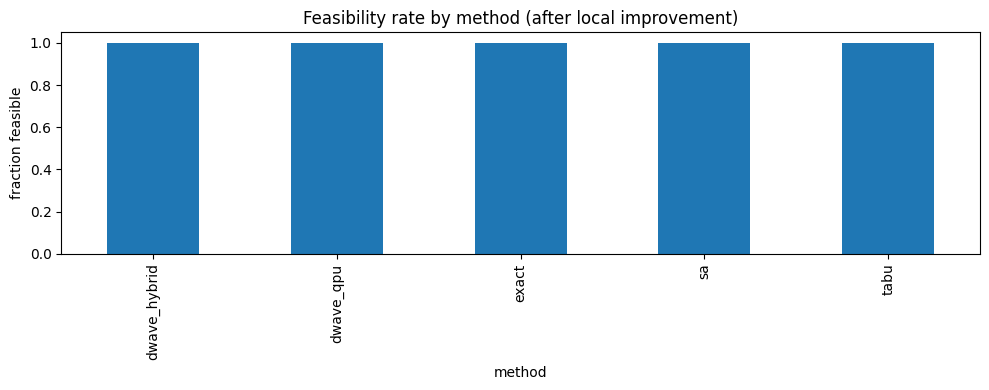

In [22]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
(ok.groupby("method")["imp_feasible"].mean().sort_values(ascending=False)
 .plot(kind="bar", ax=ax))
ax.set_title("Feasibility rate by method (after local improvement)")
ax.set_ylabel("fraction feasible")
plt.tight_layout()
plt.show()


### Plot: gap vs exact (where exact exists)

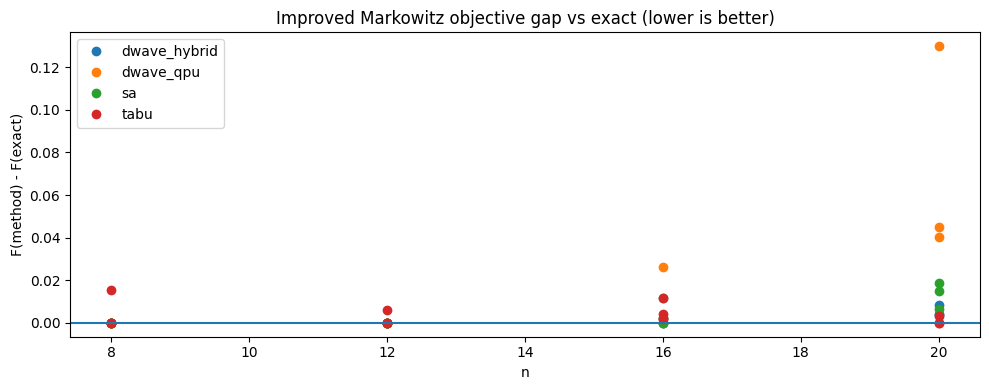

In [23]:
df_gap = ok[(ok["has_exact_ref"]) & (ok["method"]!="exact") & ok["gap_F_imp_vs_exact"].notna()].copy()
if len(df_gap) == 0:
    print("No exact references for gap plot (maybe exact skipped on all n).")
else:
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,1,1)
    for m in sorted(df_gap["method"].unique()):
        sub = df_gap[df_gap["method"]==m].sort_values("n")
        ax.plot(sub["n"], sub["gap_F_imp_vs_exact"], marker="o", linestyle="None", label=m)
    ax.axhline(0.0)
    ax.set_title("Improved Markowitz objective gap vs exact (lower is better)")
    ax.set_xlabel("n")
    ax.set_ylabel("F(method) - F(exact)")
    ax.legend()
    plt.tight_layout()
    plt.show()


## 11) Save results for Phase 4

In [24]:
OUT_CSV = "phase3_results_v2_qpu.csv"
OUT_JSON = "phase3_results_v2_qpu_with_solutions.json"

results_df.to_csv(OUT_CSV, index=False)

payload = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "phase2_source": PHASE2_JSON,
    "methods": METHODS,
    "rows": rows,  # includes solver_info
}

with open(OUT_JSON, "w") as f:
    json.dump(payload, f)

print("Saved:", OUT_CSV)
print("Saved:", OUT_JSON)


Saved: phase3_results_v2_qpu.csv
Saved: phase3_results_v2_qpu_with_solutions.json


✅ Done.

Next:
- run Phase 4 on `phase3_results_v2_qpu.csv` (and the JSON if you want QPU timing/chain-break analysis)
- if QPU embedding fails often (dense Σ), we’ll either:
  (a) rely on Hybrid for big n, QPU for small n, OR
  (b) sparsify Σ in Phase 2 to make the QUBO sparse and QPU-friendly.
